# Toxic Comment Classification

**Burak Suyunu**

**submitted to Prof. Ethem Alpaydın**

# ANN Models Notebook

In [1]:
import pandas as pd 
import numpy as np

import sys, os, re, csv, codecs

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.layers import GRU, BatchNormalization, Conv1D, MaxPooling1D
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D

from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers

from keras.callbacks import Callback
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import Adam, RMSprop

from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

from scipy import stats

import pickle

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


C:\Users\Burki\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import tensorflow as tf
from keras import backend as K

num_cores = 4

#if GPU:
#num_GPU = 4
#num_CPU = 1
#if CPU:
num_CPU = 1
num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
session = tf.Session(config=config)
K.set_session(session)

In [3]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            roc_auc_scores.append(score)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))
            print()

## Read Data

In [4]:
train = pd.read_csv("train_clean.csv")
test = pd.read_csv("test_clean.csv")
test_labels = pd.read_csv("data/test_labels.csv")

#embedding_path = "data/crawl-300d-2M.vec"
embedding_path = "data/glove.6b/glove.6B.300d.txt"

In [5]:
embed_size = 300
#max_features = 30000
#max_len = 100

In [6]:
train.head()

,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text_clean
0,0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0,explanation edit make username hardcore metall...
1,1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,daww match background colour seemingly stick t...
2,2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man really try edit war guy constantly rem...
3,3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0,make real suggestions improvement wonder secti...
4,4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,sir hero chance remember page


In [7]:
test_all = pd.merge(test, test_labels, on='id', how='outer')
test_all = test_all[test_all.toxic > -1]
test_all = test_all.reset_index(drop=True)
test_all.head()

,Unnamed: 0,id,comment_text,comment_text_clean,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,5,0001ea8717f6de06,Thank you for understanding. I think very high...,thank understand think highly would revert wit...,0,0,0,0,0,0
1,7,000247e83dcc1211,:Dear god this site is horrible.,dear god site horrible,0,0,0,0,0,0
2,11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",somebody invariably try add religion really me...,0,0,0,0,0,0
3,13,0003e1cccfd5a40a,""" \r\n\r\n It says it right there that it IS a...",say right type type institution need case thre...,0,0,0,0,0,0
4,14,00059ace3e3e9a53,""" \r\n\r\n == Before adding a new product to t...",add new product list make sure relevant add ne...,0,0,0,0,0,0


In [8]:
len(test_all)

63978

In [28]:
train_s = train
test_s = test_all

In [85]:
X_train = train_s["comment_text_clean"].fillna("fillna").values
y_train = train_s[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
X_test = test_s["comment_text_clean"].fillna("fillna").values
y_test = test_s[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values

In [86]:
max_features = 30000

In [87]:
tk = Tokenizer(num_words = max_features, lower = True)
tk.fit_on_texts(X_train)
X_train = tk.texts_to_sequences(X_train)
X_test = tk.texts_to_sequences(X_test)

In [88]:
totalNumWords = [len(one_comment) for one_comment in X_train]

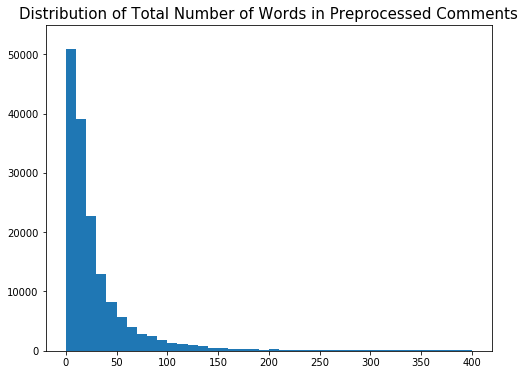

In [89]:
plt.figure(figsize=(8,6))
plt.hist(totalNumWords,bins = np.arange(0,410,10))
plt.ylim(0, 55000)
plt.title("Distribution of Total Number of Words in Preprocessed Comments", fontsize=15)
#plt.savefig("imgs/word_dist_prep.png")
plt.show()

In [34]:
max_len = 100

In [35]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

## Embedding

In [36]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path, encoding="utf8"))

In [37]:
all_embs = np.stack(embedding_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()

In [38]:
word_index = tk.word_index
nb_words = min(max_features, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

## Models

In [90]:
#https://www.kaggle.com/sbongo/for-beginners-tackling-toxic-using-keras/notebook
def build_lstm(embed = True):
    inp = Input(shape=(max_len,))
    if embed:
        x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    else:
        x = Embedding(max_features, embed_size)(inp)
    x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.1)(x)
    x = Dense(50, activation="relu", name='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(6, activation="sigmoid", name='sigmoid')(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model
    
#https://www.kaggle.com/jhoward/improved-lstm-baseline-glove-dropout/notebook
def build_bi_lstm(embed = True):
    inp = Input(shape=(max_len,))
    if embed:
        x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    else:
        x = Embedding(max_features, embed_size)(inp)
    x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1),name='bi_lstm_layer')(x)
    x = GlobalMaxPool1D()(x)
    x = Dense(50, activation="relu", name='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(6, activation="sigmoid", name='sigmoid')(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

#https://www.kaggle.com/yekenot/pooled-gru-fasttext
def build_bi_gru(embed = True):
    inp = Input(shape = (max_len,))
    if embed:
        x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    else:
        x = Embedding(max_features, embed_size)(inp)
        
    x = SpatialDropout1D(0.2)(x)
    
    x = Bidirectional(GRU(80, return_sequences=True),name='bi_gru_layer')(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    x = concatenate([avg_pool, max_pool])
    x = Dense(6, activation="sigmoid", name='sigmoid')(x)
    
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

#https://www.kaggle.com/konohayui/bi-gru-cnn-poolings/notebook
def build_bi_gru_cnn(embed = True):
    inp = Input(shape = (max_len,))
    if embed:
        x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    else:
        x = Embedding(max_features, embed_size)(inp)
        
    x = SpatialDropout1D(0.2)(x)

    x = Bidirectional(GRU(128, return_sequences = True),name='bi_gru_layer')(x)
    x = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    x = concatenate([avg_pool, max_pool])

    x = Dense(6, activation = "sigmoid", name='sigmoid')(x)
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy", optimizer = 'adam', metrics = ["accuracy"])
    
    return model



In [97]:
model = build_lstm(embed=True)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 100)               0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 100, 300)          9000000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 100, 60)           86640     
_________________________________________________________________
global_max_pooling1d_13 (Glo (None, 60)                0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 60)                0         
_________________________________________________________________
relu (Dense)                 (None, 50)                3050      
_________________________________________________________________
dropout_14 (Dropout)         (None, 50)                0         
__________

## Training

**Model training with 75% - 25% train - validation split**

In [35]:
seed = 123
X_tra, X_val, y_tra, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = seed)

ra_val = RocAucEvaluation(validation_data=(X_val, y_val), interval = 1)
early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 2)

In [36]:
model = build_lstm(embed=True)
file = open("lstm_gt_runs.txt", 'w')

In [37]:
roc_auc_scores = []

history = model.fit(X_tra, y_tra, batch_size = 256, epochs = 2, validation_data = (X_val, y_val), 
                    verbose = 1, callbacks = [ra_val, early_stop])

history.history['roc_auc'] = roc_auc_scores
file.write(str(history.history))
file.close()

Train on 119678 samples, validate on 39893 samples
Epoch 1/4
119678/119678 [==============================] - 278s 2ms/step - loss: 0.1051 - acc: 0.9685 - val_loss: 0.0503 - val_acc: 0.9819

 ROC-AUC - epoch: 1 - score: 0.971992

Epoch 2/4
119678/119678 [==============================] - 276s 2ms/step - loss: 0.0506 - acc: 0.9815 - val_loss: 0.0468 - val_acc: 0.9826

 ROC-AUC - epoch: 2 - score: 0.977497

Epoch 3/4
119678/119678 [==============================] - 277s 2ms/step - loss: 0.0433 - acc: 0.9835 - val_loss: 0.0467 - val_acc: 0.9824

 ROC-AUC - epoch: 3 - score: 0.978831

Epoch 4/4
119678/119678 [==============================] - 281s 2ms/step - loss: 0.0385 - acc: 0.9852 - val_loss: 0.0480 - val_acc: 0.9826

 ROC-AUC - epoch: 4 - score: 0.978229



**Model training with 4-fold cross validation**

In [21]:
seed = 123
kfold = StratifiedKFold(n_splits=4, shuffle=False, random_state=seed)

file = open("bi_gru_gt_kfold.txt", 'w')

for tra, val in kfold.split(X_train, np.sum(y_train, axis=1)>0):
    ra_val = RocAucEvaluation(validation_data=(X_train[val], y_train[val]), interval = 1)
    early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 2)
    
    model = build_bi_gru(embed=True)
    
    roc_auc_scores = []
    history = model.fit(X_train[tra], y_train[tra], batch_size = 256, epochs = 2,
                        validation_data = (X_train[val], y_train[val]), verbose = 1,
                        callbacks = [ra_val, early_stop])
    
    history.history['roc_auc'] = roc_auc_scores
    file.write(str(history.history))
    file.write("\n")
    
file.close()

Train on 119677 samples, validate on 39894 samples
Epoch 1/2
119677/119677 [==============================] - 841s 7ms/step - loss: 0.0789 - acc: 0.9739 - val_loss: 0.0492 - val_acc: 0.9820

 ROC-AUC - epoch: 1 - score: 0.977824

Epoch 2/2
119677/119677 [==============================] - 834s 7ms/step - loss: 0.0456 - acc: 0.9830 - val_loss: 0.0461 - val_acc: 0.9826

 ROC-AUC - epoch: 2 - score: 0.982895

Train on 119678 samples, validate on 39893 samples
Epoch 1/2
119678/119678 [==============================] - 837s 7ms/step - loss: 0.0750 - acc: 0.9759 - val_loss: 0.0505 - val_acc: 0.9819

 ROC-AUC - epoch: 1 - score: 0.976612

Epoch 2/2
119678/119678 [==============================] - 835s 7ms/step - loss: 0.0453 - acc: 0.9830 - val_loss: 0.0466 - val_acc: 0.9826

 ROC-AUC - epoch: 2 - score: 0.981837

Train on 119679 samples, validate on 39892 samples
Epoch 1/2
119679/119679 [==============================] - 836s 7ms/step - loss: 0.0783 - acc: 0.9735 - val_loss: 0.0512 - val_acc:

## Testing

**Train the model with all training data**

In [ ]:
model = build_bi_lstm(embed=True)
history = model.fit(X_train, y_train, batch_size = 256, epochs = 2,verbose = 1)

In [83]:
pred = model.predict(X_test, batch_size = 512, verbose = 1)

63978/63978 [==============================] - 115s 2ms/step


In [84]:
roc_auc_score(y_test, pred)

0.9778472285946651

In [85]:
#pickle.dump( pred, open( "bi_lstm_pred.p", "wb" ) )